<a href="https://colab.research.google.com/github/flaviorv/pb_ai_ml/blob/main/pb_tp5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

import spacy
import shap
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import Counter
from lime.lime_text import LimeTextExplainer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.manifold import TSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=09f58283ca815cddce4496ddf8e620dc1f65b64d4bfe763f9d64eabf3e3933f9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# loads pre-trained English model with POS tagging and lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def strip_html(text):
  """
  Removes HTML tags from a text.

  Args:
    text (str): A string containing text with HTML tags.

  Returns:
    str: The input text without HTML tags.
  """
  return BeautifulSoup(text, 'html.parser').get_text()

def lemmatize_text(text):
  """
  Tokenizes and lemmatizes a given text using spaCy.

  Steps:
    1. Process the text with spaCy NLP pipeline.
    2. Extract lemmas for each token.
    3. Join the lemmas into a single string.

  Args:
    text (str): The input text to be lemmatized.

  Returns:
    str: The lemmatized text as a single string with tokens joined by spaces.
  """
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

# loads the dataset
df = pd.read_csv('https://raw.githubusercontent.com/flaviorv/pb_ai_ml/refs/heads/main/datasets/IMDB%20Dataset.csv')

# cleaning and lemmatization
df['clean'] = df['review'].apply(strip_html)
df['lemmatized'] = df['clean'].apply(lemmatize_text)
print(df['lemmatized'])

0        one of the other reviewer have mention that af...
1        a wonderful little production the filming tech...
2        I think this be a wonderful way to spend time ...
3        basically there be a family where a little boy...
4        Petter Mattei 's love in the Time of money be ...
                               ...                        
49995    I think this movie do a down right good job it...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    I be a Catholic teach in parochial elementary ...
49998    I be go to have to disagree with the previous ...
49999    no one expect the Star Trek movie to be high a...
Name: lemmatized, Length: 50000, dtype: object


In [ ]:
# tf-idf
vectorizer = TfidfVectorizer(stop_words='english')
x_vec = vectorizer.fit_transform(df['lemmatized'])

print(vectorizer.get_feature_names_out())

['00' '000' '00000000000' ... 'żmijewski' 'יגאל' 'כרמון']


In [ ]:
def get_lda_topics(lda_model, feature_names, n_top_words=10):
  """
  Returns the LDA topics with their top words and relative importance.

  :param lda_model: Trained LDA model (sklearn)
  :param feature_names: Feature names provided by the TF-IDF vectorizer
  :param n_top_words: Number of top words to return per topic
  :type n_top_words: int
  :return: List of topics, each topic has the words ordered by their importance
  :rtype: List[[str]]
  """

  topics_list = []

  for topic in lda_model.components_:
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    topics_list.append(top_words)

  return topics_list

def print_lda_topics(lda_model, feature_names, n_top_words=10):
  """
  Prints the LDA topics with their top words and relative importance.

  :param lda_model: Trained LDA model (sklearn)
  :param feature_names: Feature names provided by the TF-IDF vectorizer
  :param n_top_words: Number of top words to display per topic
  :type n_top_words: int
  """

  topics = get_lda_topics(lda_model, feature_names, n_top_words)
  for topic_idx, topic in enumerate(topics):
    print(f"Topic {topic_idx}:", end=' ')
    for word_idx, word in enumerate(topic):
      print(f"{word}", end=' ') if word_idx != len(topic) -1 else print(f"{word}")

def find_best_n_topics(tfidf_vectorizer, x_vec, n_topics_list, n_top_words=10, random_state=42):
  """
  Displays the topics of each n_topics_list element and returns its LDA model.

  :param tfidf_vectorizer: TF-IDF vectorizer used to get feature names
  :param x_vec: TF-IDF matrix
  :param n_topics_list: List of topic numbers to try
  :type n_topics_list: list of int
  :param n_top_words: Number of top words per topic to use for coherence calculation
  :type n_top_words: int
  :param random_state: Random state for reproducibility
  :type random_state: int
  :return: A dict containing as key the number of topics and as value the LDA model
  """

  lda_models = {}

  for n_topics in n_topics_list:
    lda_tmp = LatentDirichletAllocation(n_components=n_topics, random_state=random_state, n_jobs=-1)
    lda_tmp.fit(x_vec)

    feature_names = tfidf_vectorizer.get_feature_names_out()
    topics = get_lda_topics(lda_tmp, feature_names)

    print(f'\nTopics: {n_topics}')
    print_lda_topics(lda_tmp, feature_names)

    lda_models[n_topics] = lda_tmp

  return lda_models

n_topics = [2, 3, 5, 7]
lda_models = find_best_n_topics(vectorizer, x_vec, n_topics)


Topics: 2
Topic 0: film story movie character life make good love great play
Topic 1: movie film bad like just watch good make really think

Topics: 3
Topic 0: film movie story life play character love good make great
Topic 1: movie film like bad good make just watch time really
Topic 2: khan akshay amitabh kapoor kumar salman govinda bachchan raj paresh

Topics: 5
Topic 0: film movie story good play love great make character life
Topic 1: movie film like bad make good just watch time really
Topic 2: akshay kumar kapoor zizek tweety amitabh dev shahrukh amrita raj
Topic 3: ghoulie rukh geena ghoulies pia rockne warhols lindbergh spanky janine
Topic 4: modesty dolemite antwone kolchak blaise lumumba sheba giovanna daffy witchery

Topics: 7
Topic 0: film movie story make good character great life love time
Topic 1: movie film bad like good make just watch time really
Topic 2: che tweety feinstone soderbergh sylvester guevara shahrukh juhi mathieu kasparov
Topic 3: khan salman akshay ami

In [9]:
# getting (n_documents, n_topics)
topic_distribution = lda_models[7].transform(x_vec)

# dominant topic of each token
dominant_topic = topic_distribution.argmax(axis=1)

# topics by document
topic_counts = Counter(dominant_topic)
count = [print(f'Topic {t} Count {c}') for t, c in topic_counts.items()]

Topic 0 Count 15285
Topic 1 Count 34686
Topic 5 Count 5
Topic 3 Count 12
Topic 4 Count 7
Topic 2 Count 2
Topic 6 Count 3


Random Forest best param: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      5979
           1       0.78      0.90      0.83      6521

    accuracy                           0.81     12500
   macro avg       0.82      0.81      0.81     12500
weighted avg       0.82      0.81      0.81     12500



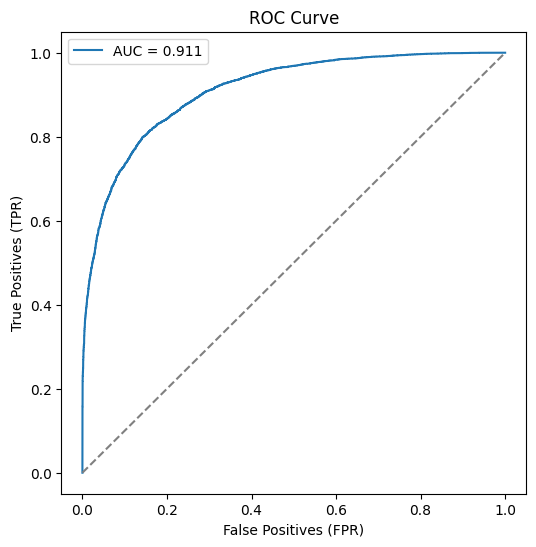

In [ ]:
# features and the target
x = x_vec
y = dominant_topic

# dividing between train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

# model
rfc = RandomForestClassifier(random_state=42)

# hyperparameter search
grid_params = {
  'n_estimators': [300, 400],
  'max_depth': [10, 15, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}

# grid search and predictions with the best model
grid = RandomizedSearchCV(rfc, grid_params, cv=3, n_iter=5, scoring='f1_macro', n_jobs=-1)
grid.fit(x_train, y_train)
y_pred = grid.predict(x_test)

# recall, precision, f1-score, accuracy
print('Random Forest best param:', grid.best_params_)
print(classification_report(y_test, y_pred))

# roc curve and auc
y_proba = grid.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positives (FPR)")
plt.ylabel("True Positives (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

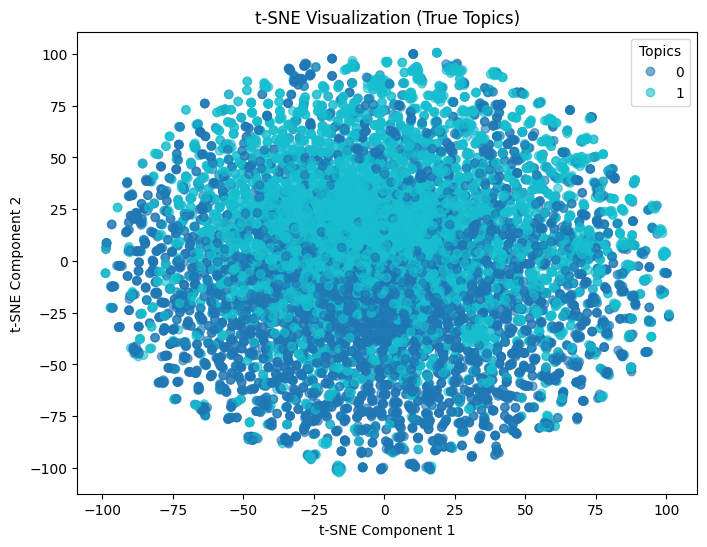

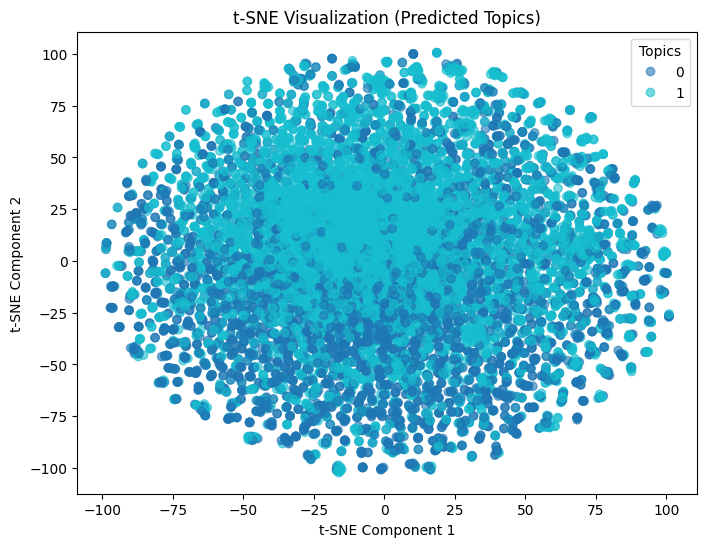

In [ ]:
# t-SNE for dimentionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000, init='random')
x_test_2d = tsne.fit_transform(x_test)

# ploting the clusters with the real tests
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_test_2d[:,0], x_test_2d[:,1], c=y_test, cmap='tab10', alpha=0.6)
plt.title("t-SNE Visualization (True Topics)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(*scatter.legend_elements(), title="Topics")
plt.show()

# ploting the clusters with the predicted tests
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_test_2d[:,0], x_test_2d[:,1], c=y_pred, cmap='tab10', alpha=0.6)
plt.title("t-SNE Visualization (Predicted Topics)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(*scatter.legend_elements(), title="Topics")
plt.show()


In [ ]:
# initializing lime explainer
explainer_lime = LimeTextExplainer(class_names=['Topic 0' ,'Topic 1'])

# getting a instance
idx = 10
doc_text = df['review'].iloc[idx]

# lime probabilities function
predict_fn = lambda texts: grid.best_estimator_.predict_proba(vectorizer.transform(texts))

# explain the instance
exp = explainer_lime.explain_instance(doc_text, predict_fn, num_features=10)
exp.show_in_notebook(text=False)
